In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 6
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [97]:
from keras import backend as K
%run survey_lcs.py 64 2 0.25 --model_type gru --lr 5e-4 --sim_type survey_lcs/n200_periodic --nb_epoch 1 --n_min 200 --n_max 200 --m_max 32 --embedding 64

/Users/brettnaul/Dropbox/Documents/timeflow/survey_lcs.py:61: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  X, scale_params = preprocess(X_raw, args.m_max)


NameError: name 'LombScargleFast' is not defined

# Visualizing predictions

In [6]:
%%time
pred = model.predict({'main_input': X, 'aux_input': X[:, :, [0,]]}, batch_size=500)

CPU times: user 15min 39s, sys: 3min 36s, total: 19min 16s
Wall time: 3min 58s


In [7]:
i = -1

In [96]:
np.sum(best_scores > 0.075)

/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


6066

In [93]:
%%time
from gatspy.periodic import LombScargleFast

best_scores = np.zeros(len(X))
for i in range(len(X)):
    t = X[i, :, 0]
    m = X[i, :, 1]
    opt_args = {'period_range': (0.05 * (t.max() - t.min()), 0.95 * (t.max() - t.min())), 'quiet': True}
    model_gat = LombScargleFast(fit_period=True, optimizer_kwds=opt_args,
                                silence_warnings=True)
    model_gat.fit(t, m)
    best_scores[i] = model_gat.score(model_gat.best_period).item()

/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/gatspy/periodic/lomb_scargle_fast.py:324: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS) / YY
/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/gatspy/periodic/lomb_scargle_fast.py:324: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS) / YY
/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/gatspy/periodic/lomb_scargle_fast.py:324: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS) / YY
/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/gatspy/periodic/lomb_scargle_fast.py:324: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS) / YY
/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/gatspy/periodic/lomb_scargle_fast.py:324: RuntimeWarning: invalid value encountered in true_di

CPU times: user 36min 11s, sys: 52.3 s, total: 37min 3s
Wall time: 9min 28s


/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


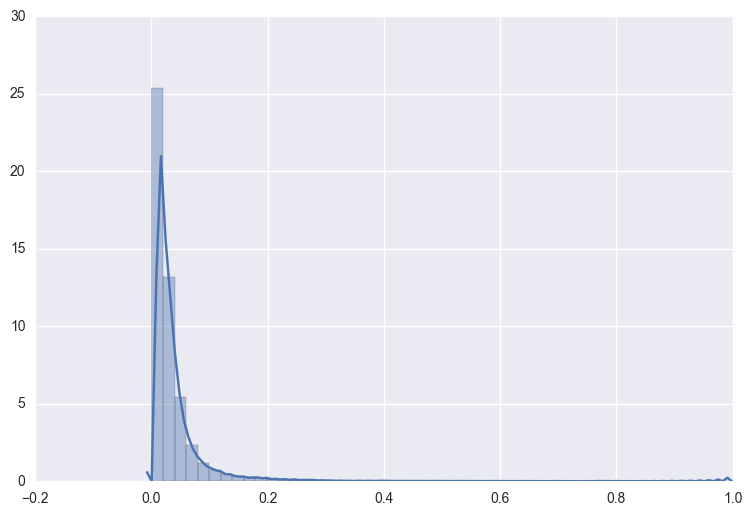

In [68]:
sns.distplot(best_scores[~np.isnan(best_scores)])

/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnin

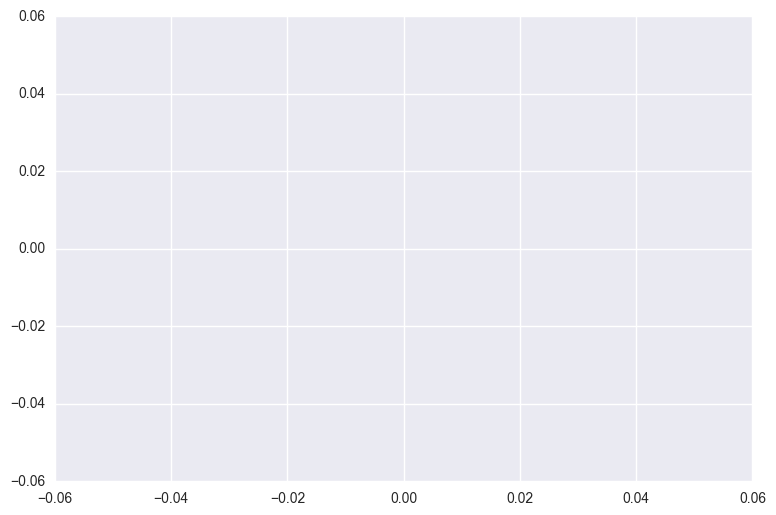

In [92]:
sns.kdeplot(best_scores, cumulative=True)

0.05086905103578158


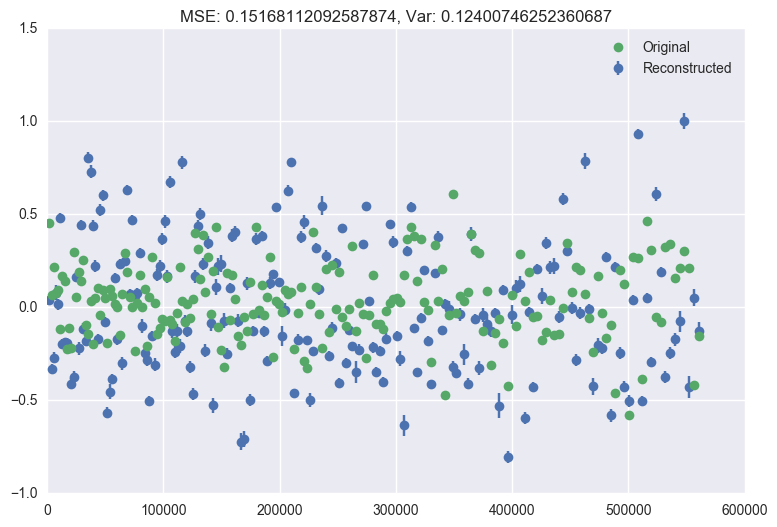

In [90]:
#inds = ~np.isnan(X_raw[i, :, 0])
inds = np.arange(args.n_min)
#i += 1
i = np.random.choice(inds)
t = np.cumsum(X_raw[i, inds, 0])
m = X[i, inds, 1]
#m = np.random.normal(size=len(t))
e = X_raw[i, inds, 2]
pred_i = model.predict({'main_input': X[i:i+1], 'aux_input': X[i:i+1, :, [0,]]})[0, inds, 0]

plt.errorbar(t, m, e, None, 'o');
plt.plot(t, pred[i], 'o');

from gatspy.periodic import LombScargleFast

gat_resids = np.zeros(len(X))
model_gat = LombScargleFast(fit_period=True, optimizer_kwds={'period_range': (0.05 * (t.max() - t.min()), 0.95 * (t.max() - t.min())), 'quiet': True}, silence_warnings=True)
model_gat.fit(t, m)
print(model_gat.score(model_gat.best_period).item())

#w_r, A_r, phi_r, b_r = pred_gru[i]
#x_r = A_r * np.sin(2 * np.pi * w_r * t + phi_r) + b_r
#plt.plot(t, x_r, '--')

plt.legend(['Original', 'Reconstructed'])
plt.title("MSE: {}, Var: {}".format((np.mean((m - np.squeeze(pred[i])) ** 2)), np.var(m)));

# Visualizing training progress

In [ ]:
import glob
import os

log_files = glob.glob(os.path.join('keras_logs', 'autoencoder/uneven/noise0') + '/*.csv')
logs = [pd.read_csv(f, usecols=['Wall time', 'Step', 'Value']) for f in log_files]
for log, f in zip(logs, log_files):
    label = f[(f.rfind('run_') + 4):f.rfind(',')] + ' ' + ('Validation' if 'val' in f else 'Training')
    log.columns = [label if c == 'Value' else c for c in log.columns]
    log['Wall time'] -= log['Wall time'].min()
time_logs = pd.concat([l.set_index('Wall time').drop('Step', axis=1) for l in logs], axis=1)
step_logs = pd.concat([l.set_index('Step').drop('Wall time', axis=1) for l in logs], axis=1)
step_logs.head(10)

In [ ]:
step_logs.plot?

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

colors = sns.color_palette(n_colors=int(len(step_logs.columns) / 2))
for i, c in enumerate(step_logs.columns):
    step_logs[c].dropna().plot(ax=ax[0], color=colors[int(i / 2)], legend=True, linestyle='-' if 'Training' in c else '--')
    time_logs[c].dropna().plot(ax=ax[1], color=colors[int(i / 2)], legend=True, linestyle='-' if 'Training' in c else '--')
ax[0].set_ylabel('Loss');
ax[1].set_ylabel('Loss');
ax[1].set_xlabel('Wall time (s)');

# Visualizing embeddings

In [ ]:
%%time
inds = np.arange(args.N_train, args.N_train + args.N_test)
encode_layer = [l for l in model.layers if l.name == 'encoding'][0]
if args.even:
    encode = K.function([model.layers[0].input], [encode_layer.output])
    encoding, = encode([X[inds]])
else:
    inputs = [l for l in model.layers if 'Input' in str(l)]
    encode = K.function([inputs[0].input, inputs[1].input], [encode_layer.output])
    encoding, = encode([X[inds], X[inds, :, 0:1]])

In [ ]:
np.mean((m - pred_i) ** 2)

In [ ]:
S = np.corrcoef(encoding, Y[:encoding.shape[0]], rowvar=0)[:8, 8:]
print(pd.DataFrame(S))
plt.imshow(S, cmap='viridis', interpolation='none')
plt.colorbar()

In [ ]:
sns.jointplot(encoding[:, 5], Y[:encoding.shape[0], 0], kind='hex')

In [ ]:
sns.jointplot(encoding[:, 1], Y[:encoding.shape[0], 1], kind='hex')

In [ ]:
sns.jointplot(encoding[:, 5], Y[:encoding.shape[0], 2], kind='hex')

In [ ]:
sns.jointplot(encoding[:, 3], Y[:encoding.shape[0], 3], kind='hex')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

model = RandomForestRegressor(n_estimators=128)
#model = ElasticNet()
#model = SVR(kernel='rbf')

model.fit(encoding, Y[:encoding.shape[0], 0])

In [ ]:
encoding_test = encode([X[test]])[0]
Y_pred = model.predict(encoding_test)

In [ ]:
#sns.jointplot(Y[test, 0], Y_pred[:, 0])
sns.jointplot(Y[test, 0], Y_pred)